# data

In [40]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import matplotlib.image as mpimg
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
root_dir = 'Dataset_BUSI_with_GT/'
path = Path(root_dir)

image_paths = list(path.glob('*/*.png'))

images = [str(image_path) for image_path in image_paths if '_mask' not in str(image_path)]
masks = [str(image_path) for image_path in image_paths if '_mask' in str(image_path)]
labels = [os.path.split(os.path.split(name)[0])[1] for name in images]

classes = list(set(labels))
labels_dict = {label : i for i,label in enumerate(classes)}
labels = [labels_dict[label_key] for label_key in labels]

In [10]:
# Splitting data into train, test and validation set
train_data,test_data,train_labels,test_labels = train_test_split(images,labels,test_size=0.15,shuffle=True,random_state=12)
train_data,val_data,train_labels,val_labels = train_test_split(train_data,train_labels,test_size=0.15,shuffle=True,random_state=12)

# Transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )                                   
                                      ])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class Dataset(Dataset):
    def __init__(self,images:list,labels:list,transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        image = self.transform(image)
        label = self.labels[index]
        return image, label


train_dataset = Dataset(images=train_data,labels=train_labels,transform=train_transforms)
val_dataset = Dataset(images=val_data,labels=val_labels,transform=val_transforms)
test_dataset = Dataset(images=test_data,labels=test_labels,transform=val_transforms)

train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=4,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=4,shuffle=False)

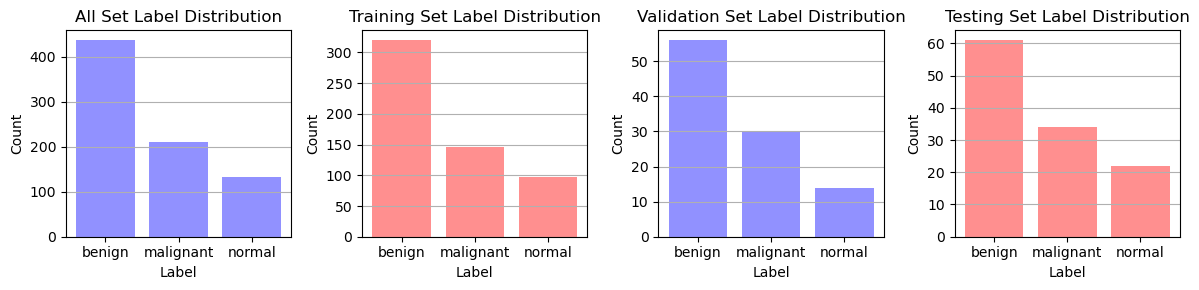

In [34]:
import pandas as pd
reversed_labels_dict = {value: key for key, value in labels_dict.items()}
# Visualization of Label Distribution
fig, axes = plt.subplots(1, 4, figsize=(12,3 ))

color_set=['#6262ff','#ff6060','#6262ff','#ff6060']
title_set=['All','Training','Validation','Testing']
j=0
for i in [labels,train_labels,val_labels,test_labels]:
    values_cnt=pd.DataFrame(pd.Series(i).value_counts())
    values_cnt.index = values_cnt.index.map(reversed_labels_dict)
    axes[j].bar(values_cnt.index,values_cnt['count'], color=color_set[j], alpha=0.7, ls='--')
    axes[j].set_title('{} Set Label Distribution'.format(title_set[j]))
    axes[j].set_xlabel('Label')
    axes[j].set_ylabel('Count')
    axes[j].grid(axis='y')
    j+=1
plt.tight_layout()
plt.show()

In [32]:
labels_dict

{'malignant': 0, 'normal': 1, 'benign': 2}

In [35]:
pd.DataFrame(pd.Series(labels).value_counts())

,count
2,437
0,210
1,133


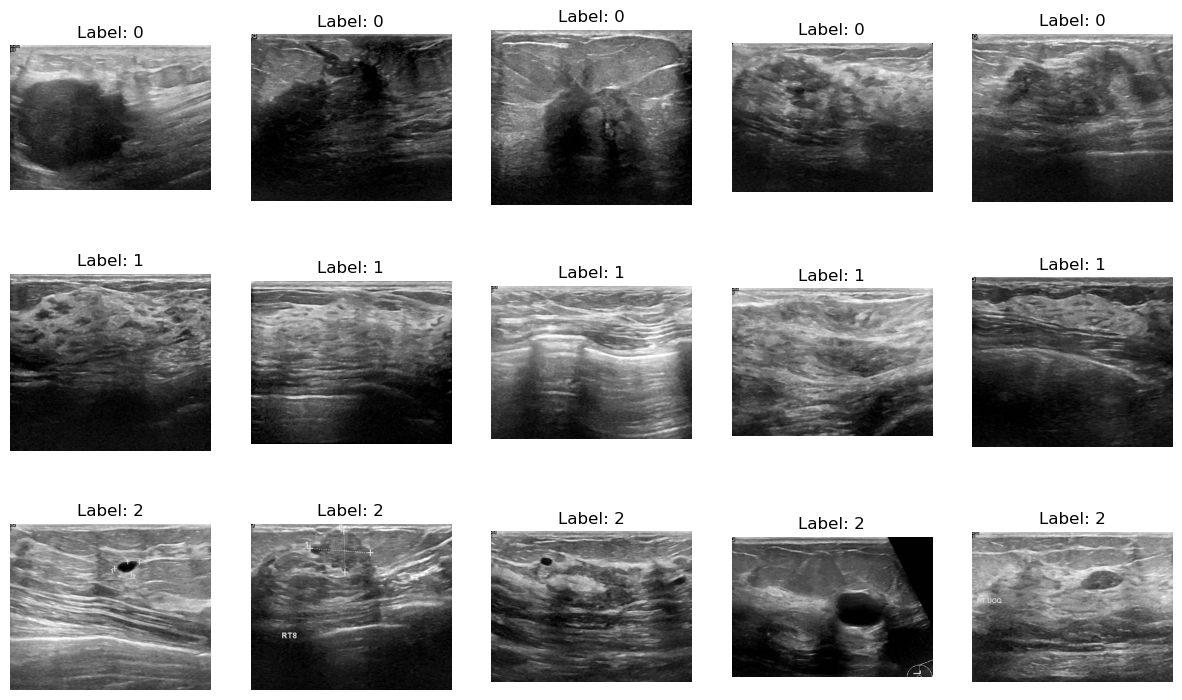

In [39]:
# Display 5 examples for each label
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  #  Set up the subplot layout
unique_labels = np.unique(labels)  
for row, label in enumerate(unique_labels):
    label_indices = np.where(np.array(labels) == label)[0][:5]  # Properly use the axes index
    for col, idx in enumerate(label_indices):
        ax = axes[row, col]  
        img_path = images[idx]  
        img = mpimg.imread(img_path)  
        ax.imshow(img, cmap='gray')  
        ax.set_title(f"Label: {label}") 
        ax.axis('off')  

# train

In [19]:
import torch
from timeit import default_timer as timer
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def accuracy_fxn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    # How many of y_true == y_pred
    acc = (correct/len(y_pred))
    return acc

# Training and Testing Steps & Loop functions
def train_step(model,dataloader,loss_fxn,accuracy,optimizer,scheduler,device):
    model.train()
    train_loss, train_acc = 0,0
    for images,labels in dataloader:
        images,labels = images.to(device),labels.to(device)

        # Forward Pass
        logit = model(images)
        prob = torch.softmax(logit,dim=1)
        pred = torch.argmax(prob,dim=1)

        # Loss and Accuracy
        loss = loss_fxn(logit,labels)
        train_loss += loss
        train_acc += accuracy(y_true=labels,y_pred=pred)

        # Zero grad, back prop, step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    scheduler.step()

    # Average loss and accuracy across all batches
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss,train_acc


def val_step(model,dataloader,loss_fxn,accuracy,device):
    model.eval()
    val_loss,val_acc = 0,0
    target_labels = []
    pred_probs = []

    # Turn off gradient tracking
    with torch.inference_mode():
        for images,labels in dataloader:
            images,labels = images.to(device),labels.to(device)

            # Forward Pass
            logit = model(images)
            prob = torch.softmax(logit,dim=1)
            pred = torch.argmax(prob,dim=1)

            pred_probs.append(prob.cpu())
            target_labels.append(labels.cpu())

            # Loss and Accuracy
            loss = loss_fxn(logit,labels)
            val_loss += loss
            val_acc += accuracy(y_true=labels,y_pred=pred)
        
        pred_probs = torch.cat(pred_probs)
        target_labels = torch.cat(target_labels)

        # Average loss and accuracy across all batches
        val_loss /= len(dataloader)
        val_acc /= len(dataloader)

    return val_loss,val_acc

def train_model(epochs,model,train_loader,val_loader,loss_fxn,accuracy,optimizer,scheduler,device):
    # Create empty results dict that keeps track of metrics per epoch
    results = {
        'train_loss':[],
        'train_acc':[],
        'val_loss':[],
        'val_acc':[]
    }
    start_time = timer()

    for epoch in tqdm(range(epochs), desc='Training Model...'):
        train_loss,train_acc = train_step(model,train_loader,loss_fxn,accuracy,optimizer,scheduler,device)
        test_loss,test_acc = val_step(model,val_loader,loss_fxn,accuracy,device)

        print(f'Epoch: {epoch+1}\n----------')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {test_loss:.4f} | Val Acc: {test_acc*100:.2f}%')

        results['train_loss'].append(train_loss.item())
        results['train_acc'].append(train_acc)
        results['val_loss'].append(test_loss.item())
        results['val_acc'].append(test_acc)
    
    end_time = timer()
    print(f"Execution time on {device}: {format(end_time-start_time, '0.3f')} seconds.")

    return results,model

   

# model

In [29]:
epochs = 10
weights = models.ResNet50_Weights.DEFAULT
# Instatiate
pt_model = models.resnet50(weights=weights)
# Get number of input features into linear layer
features = pt_model.fc.in_features
# Modify classifier output shape 
pt_model.fc = nn.Linear(features, num_classes)

pt_model = pt_model.to(device)

criterion = nn.CrossEntropyLoss()
accuracy = accuracy_fxn

optimizer = torch.optim.Adam(pt_model.parameters(),lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=4,gamma=0.225)

results,model = train_model(epochs,pt_model,train_loader,val_loader,criterion,accuracy_fxn,optimizer,scheduler,device=device)


Training Model...:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
----------
Train Loss: 0.8419 | Train Acc: 61.58% | Val Loss: 0.6956 | Val Acc: 73.00%
Epoch: 2
----------
Train Loss: 0.5745 | Train Acc: 75.47% | Val Loss: 0.5899 | Val Acc: 82.00%
Epoch: 3
----------
Train Loss: 0.4561 | Train Acc: 81.86% | Val Loss: 0.5352 | Val Acc: 82.00%
Epoch: 4
----------
Train Loss: 0.3894 | Train Acc: 85.46% | Val Loss: 0.4290 | Val Acc: 84.00%
Epoch: 5
----------
Train Loss: 0.2659 | Train Acc: 92.55% | Val Loss: 0.4261 | Val Acc: 83.00%
Epoch: 6
----------
Train Loss: 0.1927 | Train Acc: 94.15% | Val Loss: 0.4214 | Val Acc: 88.00%
Epoch: 7
----------
Train Loss: 0.1497 | Train Acc: 94.50% | Val Loss: 0.4815 | Val Acc: 88.00%
Epoch: 8
----------
Train Loss: 0.1652 | Train Acc: 94.68% | Val Loss: 0.4120 | Val Acc: 87.00%
Epoch: 9
----------
Train Loss: 0.1362 | Train Acc: 95.74% | Val Loss: 0.4140 | Val Acc: 88.00%
Epoch: 10
----------
Train Loss: 0.1497 | Train Acc: 95.51% | Val Loss: 0.4306 | Val Acc: 89.00%
Execution time on cpu: 732.768 seconds.

# plot

In [20]:
import matplotlib.pyplot as plt

def plot_loss_acc(results):
    epochs = [i for i in range(len(results['val_acc']))]

    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plt.plot(epochs,results['train_loss'],label='Train Loss Curve')
    plt.plot(epochs,results['val_loss'],label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs,results['train_acc'],label='Train Accuracy')
    plt.plot(epochs,results['val_acc'],label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

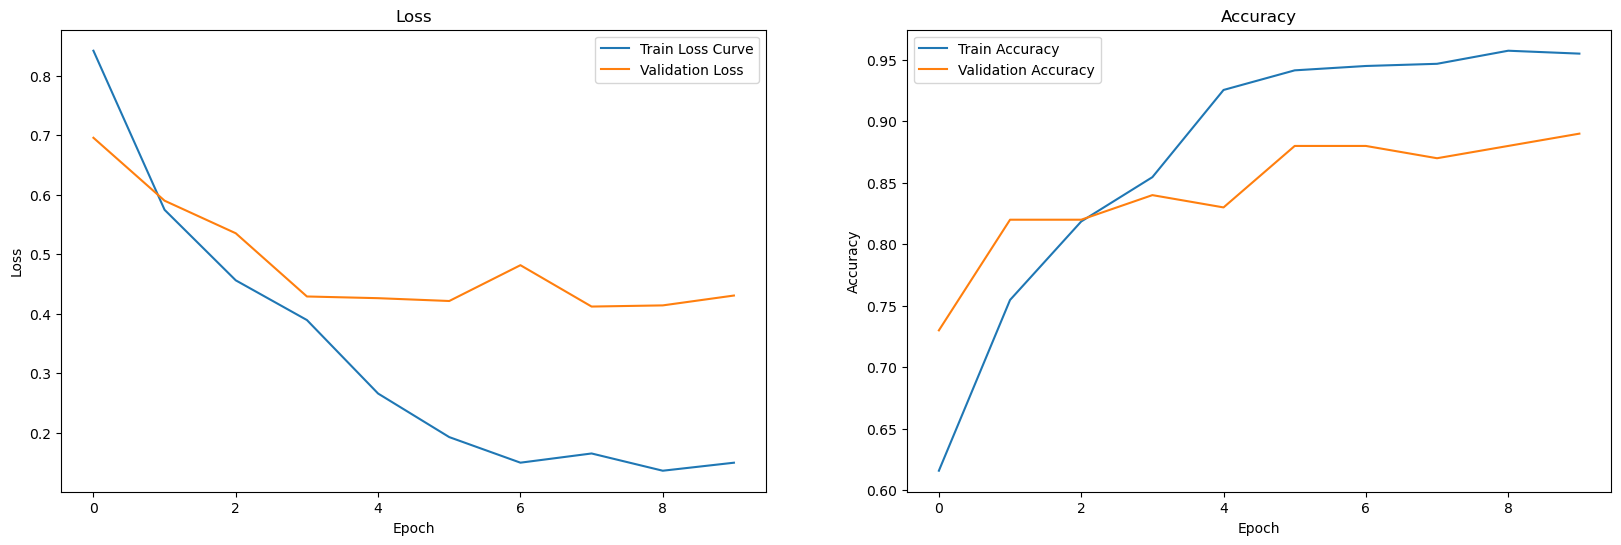

In [30]:
plot_loss_acc(results)

# test

Test Accuracy: 0.9060
Test Precision: 0.9060
Test Recall: 0.9060
F1 Score: 0.9060
sensitivity: 0.9060
specificity: 0.9530
AUC: 0.9716


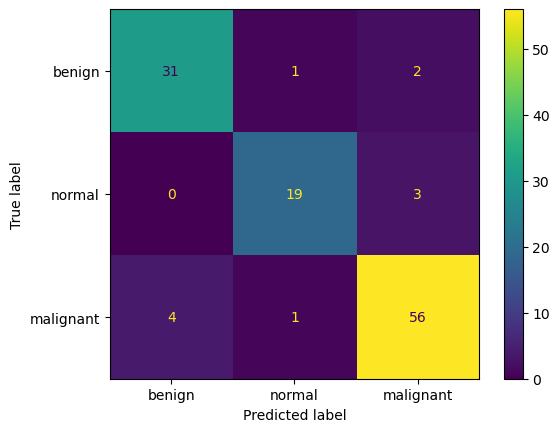

In [31]:
import torch
from torchmetrics import Accuracy,Precision,Recall,F1Score,Recall, Specificity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# import data
# import model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_model(model,dataloader,device):
    # Storing pred labels
    prediction_labels = []
    prediction_probs = []

    # Testing all testing data
    model.eval()

    with torch.inference_mode():
        for images, labels in dataloader:
            images,labels = images.to(device), labels.to(device)

            logits = model(images)
            prob = torch.softmax(logits, dim=1)
            labels = torch.argmax(prob, dim=1)

            prediction_labels.append(labels.cpu())
            prediction_probs.append(prob.cpu())

        # Concatenate all tensors in predictions list into big tensor
        prediction_labels = torch.cat(prediction_labels)
        prediction_probs = torch.cat(prediction_probs)

        return prediction_labels,prediction_probs

target_labels = []
for img,label in test_dataset:
    target_labels.append(label)

accuracy = Accuracy(task='multiclass',num_classes=3).to(device)
precision = Precision(task='multiclass',num_classes=3).to(device)
recall = Recall(task='multiclass',num_classes=3).to(device)
f1_score = F1Score(task='multiclass',num_classes=3)
sensitivity=Recall(task='multiclass',num_classes=3)
specificity=Specificity(task='multiclass',num_classes=3)

model = model

predicted_labels,predicted_probs = test_model(model,test_loader,device=device)

test_accuracy = accuracy(predicted_labels, torch.Tensor(target_labels).type(dtype=torch.int))
test_precision = precision(predicted_labels, torch.Tensor(target_labels).type(dtype=torch.int))
test_recall = recall(predicted_labels, torch.Tensor(target_labels).type(dtype=torch.int))
f1_score = f1_score(predicted_labels, torch.Tensor(target_labels).type(dtype=torch.int))
auc = roc_auc_score(target_labels, predicted_probs, multi_class='ovr')
sensitivity = sensitivity(predicted_labels, torch.Tensor(target_labels).type(dtype=torch.int))
specificity = specificity(predicted_labels, torch.Tensor(target_labels).type(dtype=torch.int))

print(f"Test Accuracy: {test_accuracy.item():.4f}")
print(f"Test Precision: {test_precision.item():.4f}")
print(f"Test Recall: {test_recall.item():.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"sensitivity: {sensitivity:.4f}")
print(f"specificity: {specificity:.4f}")
print(f"AUC: {auc:.4f}")

cm = confusion_matrix(target_labels,predicted_labels,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['benign','normal','malignant'])
disp.plot()
plt.show()